# OLAP Analysis: Top Sales Performance by Store

Author: Elom Gbogbo

Date: 4-18-25

Business Goal: Identify which store(s) consistently perform the best in total sales over time. 

## Imports

In [114]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import sys

## Load the Data

In [115]:

print("Current working directory:", os.getcwd())
print("Does DB exist?:", os.path.exists("data/dw/smart_sales.db"))


Current working directory: c:\Projects\smart-store-egbogbo\scripts
Does DB exist?: False


In [116]:
# Connect to database
conn = sqlite3.connect("../data/dw/smart_sales.db")

cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")


In [117]:
df_sales = pd.read_sql_query("SELECT * FROM sale", conn)
print(df_sales.head())

   transaction_id  customer_id  product_id  store_id  sale_amount   sale_date  \
0             550         1008         102       404        39.10  2024-01-06   
1             551         1009         105       403        19.78  2024-01-06   
2             552         1004         107       404       335.10  2024-01-16   
3             553         1006         102       406       195.50  2024-01-16   
4             554         1005         102       405       117.30  2024-01-25   

   campaign_id  discount_percent payment_type  
0            0              0.35         Cash  
1            0              0.45       Credit  
2            0              0.60        Debit  
3            0              0.10       Credit  
4            0              0.20         Cash  


In [118]:
df_products = pd.read_sql_query('SELECT * FROM product', conn)
print(df_products.head())


   product_id product_name     category  unit_price  stock_quantity supplier
0         101       laptop  Electronics     793.121             160    Apple
1         102       hoodie     Clothing      39.100             200     Nike
2         103        cable  Electronics      22.760              70  Samsung
3         104          hat     Clothing      43.100              53   NewEra
4         105     football       Sports      19.780             132   Wilson


In [119]:
df_customers = pd.read_sql_query('SELECT * FROM customer', conn)
print(df_customers.head())

   customer_id           name region   join_date  loyalty_points  \
0         1001  William White   East  11/11/2021             123   
1         1002   Wylie Coyote   East   2/14/2023             456   
2         1003      Dan Brown   West  10/19/2023             789   
3         1004      Chewbacca   West   11/9/2022             654   
4         1005         Dr Who  North   8/18/2023             333   

  preferred_contact_method standard_date_time  
0                     Call         2021-11-11  
1                    Email         2023-02-14  
2                    Email         2023-10-19  
3                     Text         2022-11-09  
4                    Email         2023-08-18  


## Merge and Prepare Data

In [120]:
df = df_sales.merge(df_customers, on="customer_id", how="left")
df = df.merge(df_products, on="product_id", how="left")
df["sale_date"] = pd.to_datetime(df["sale_date"])
df["year"] = df["sale_date"].dt.year
df["month"] = df["sale_date"].dt.month

## OLAP - Slicing, Dicing, and Drilldown

In [121]:
# Slicing: Electronic Sales by Store
df_slice = df[df["category"] == "Electronics"]
df_slice_agg = df_slice.groupby('store_id')["sale_amount"].sum().sort_values(ascending=False)

<function matplotlib.pyplot.show(close=None, block=None)>

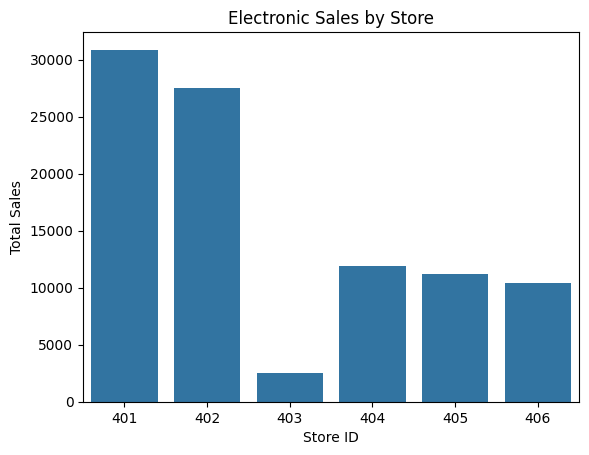

In [122]:
# Visualization
sns.barplot(x=df_slice_agg.index, y=df_slice_agg.values)
plt.title("Electronic Sales by Store")
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.show

In [123]:
# Dicing: Sales broken down by store, product category, and year
df_dice = df.groupby(["store_id", "category", "year"])["sale_amount"].sum().reset_index()

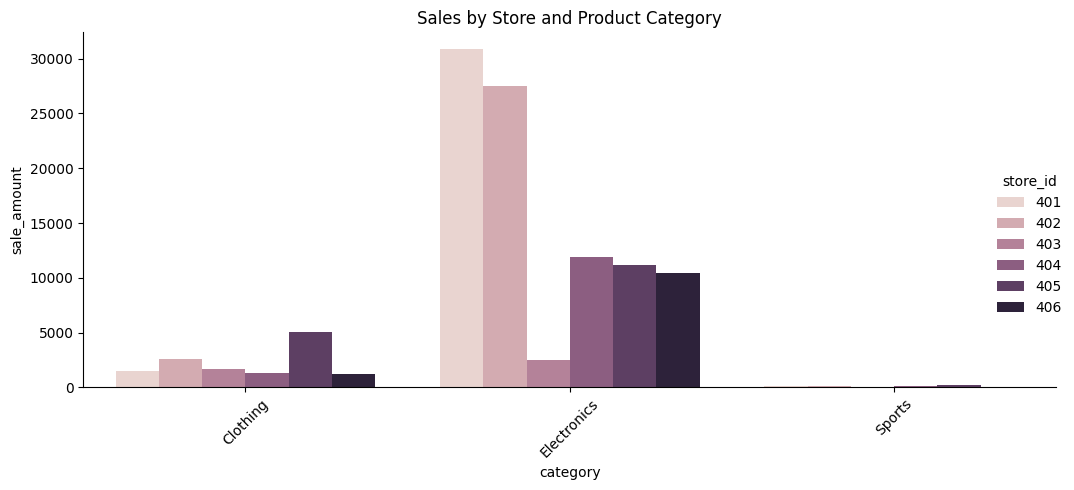

In [124]:
# Visualization
sns.catplot(data=df_dice, x="category", y="sale_amount", hue="store_id", kind="bar", height=5, aspect=2)
plt.title("Sales by Store and Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [125]:
# Drilldown: Daily sales trend by store, grouped by month
df["date"] = df["sale_date"].dt.date
df_drilldown = df.groupby(["store_id", "date"])["sale_amount"].sum().reset_index()

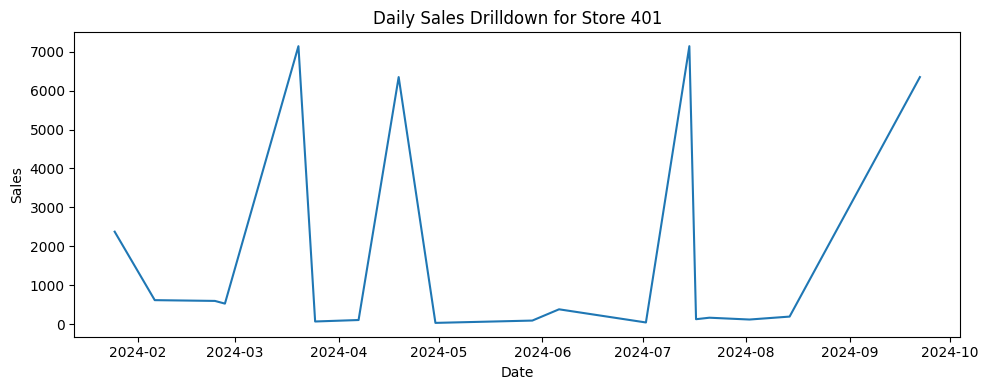

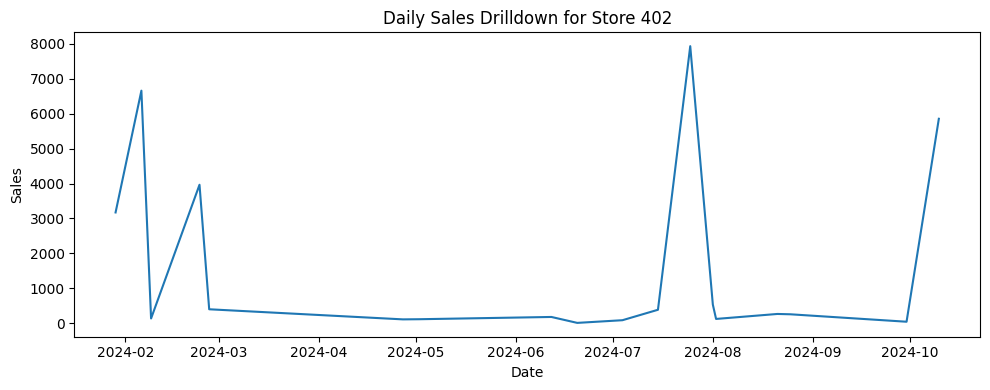

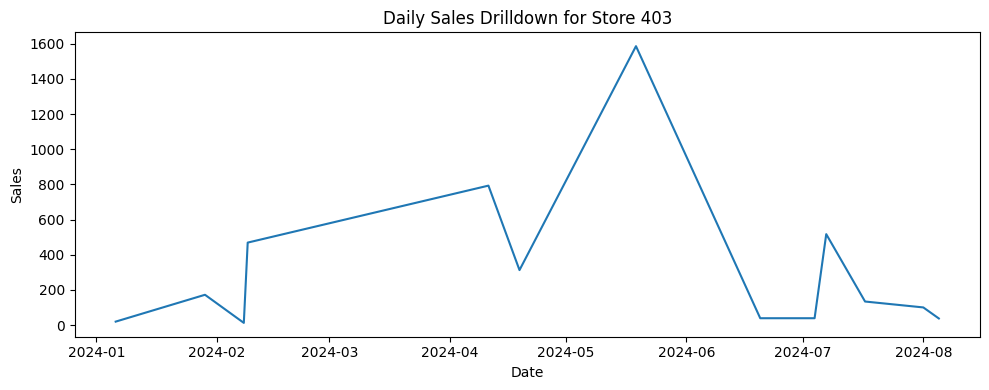

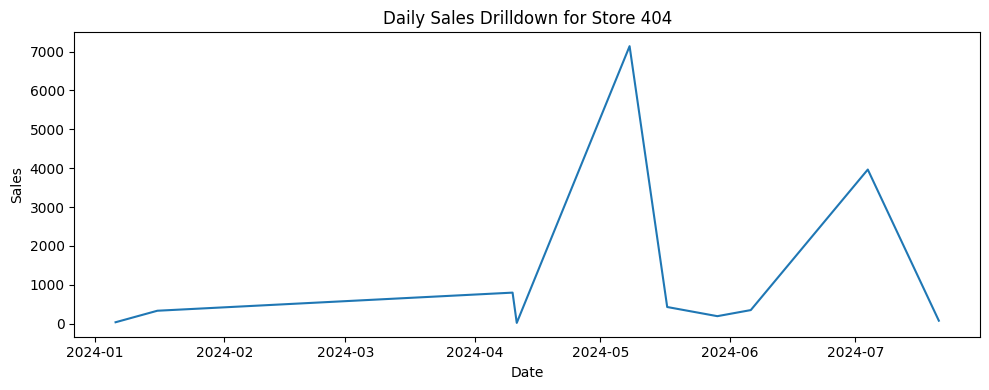

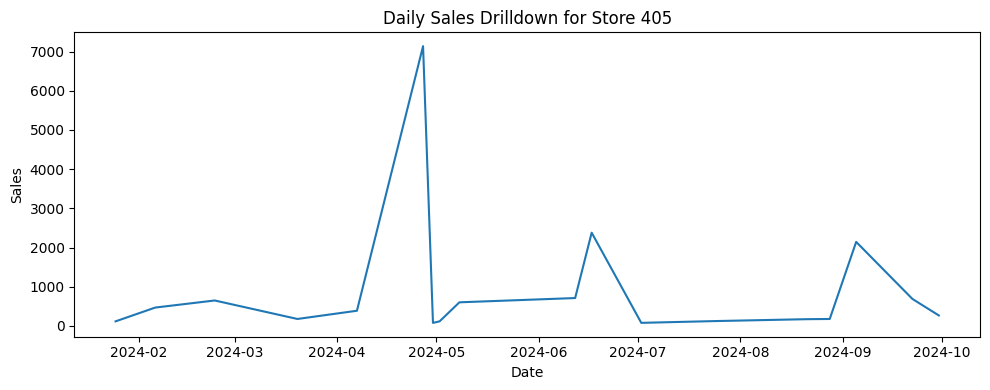

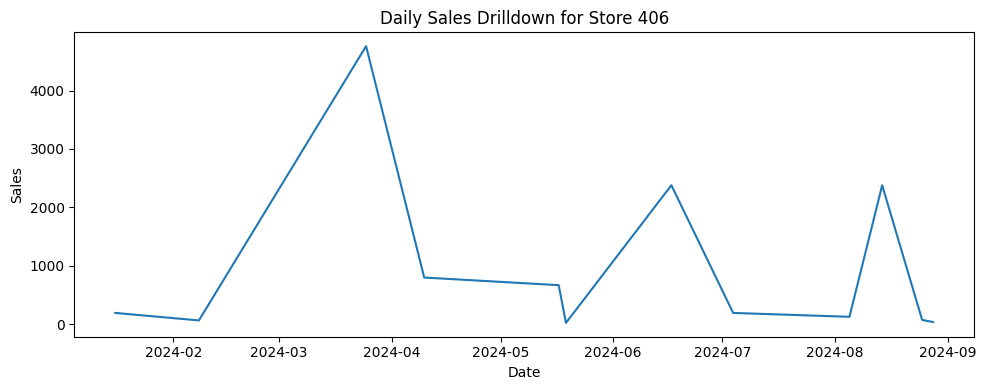

In [126]:
# Visualization
unique_stores = df_drilldown["store_id"].unique()
for store in unique_stores:
    store_data = df_drilldown[df_drilldown["store_id"] == store]
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=store_data, x="date", y="sale_amount")
    plt.title(f"Daily Sales Drilldown for Store {store}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.tight_layout()
    plt.show()

In [127]:
# Aggregate total and average sales by store
df_agg = df.groupby(["store_id", "year", "month"]).agg(
    total_sales=pd.NamedAgg(column="sale_amount", aggfunc="sum"),
    avg_sales=pd.NamedAgg(column="sale_amount", aggfunc="mean")
).reset_index

## Visualizations 

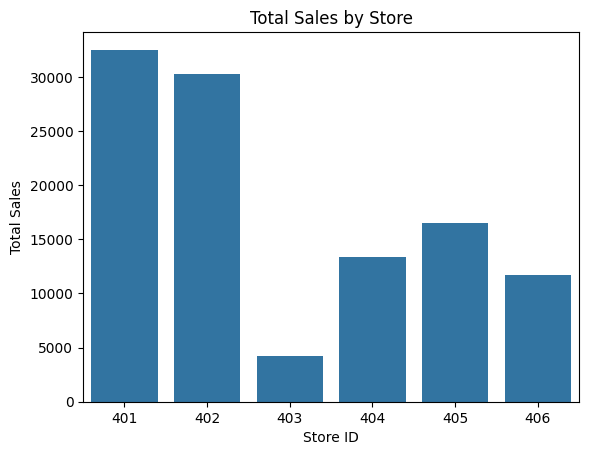

In [132]:
# Total Sales by Stores
top_stores = df.groupby("store_id")["sale_amount"].sum().sort_values(ascending=False)
sns.barplot(y=top_stores.values, x=top_stores.index)
plt.title("Total Sales by Store")
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.show()

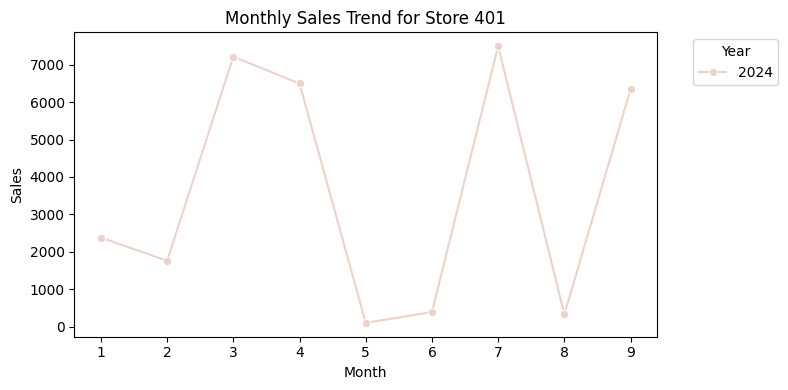

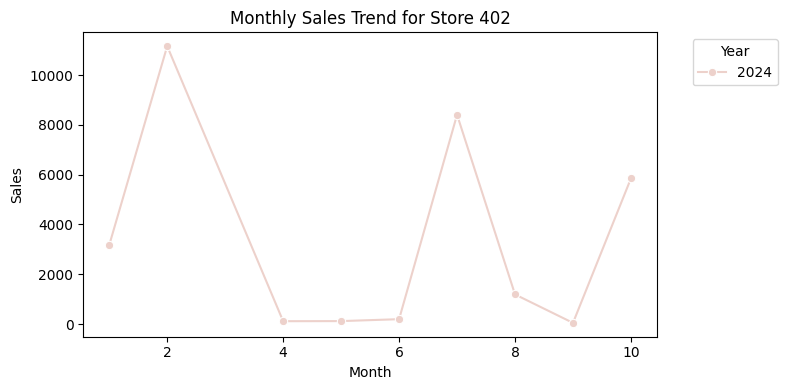

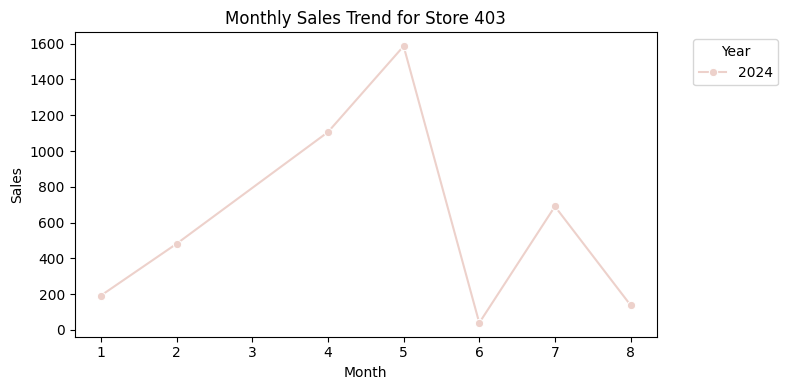

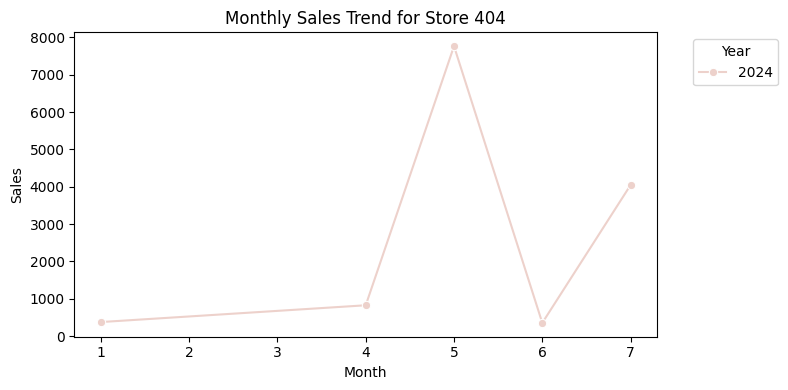

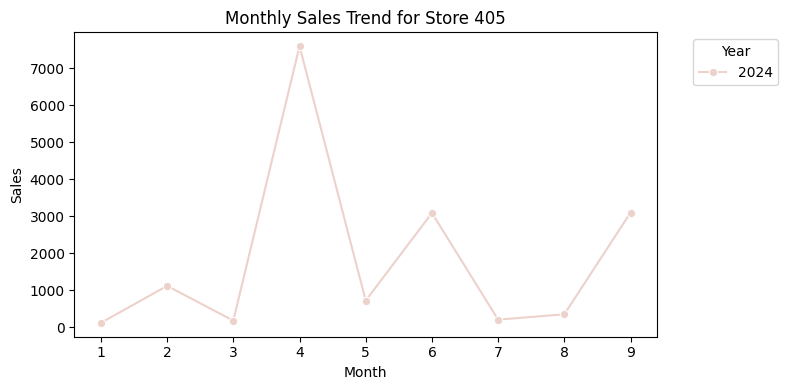

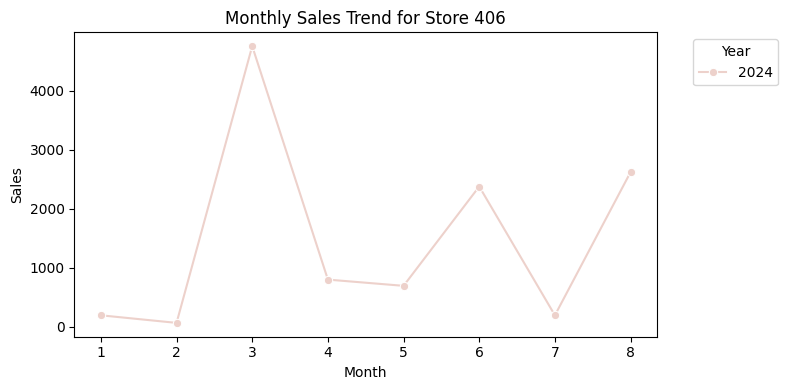

In [133]:
df_monthly_all = df.groupby(["store_id", "year", "month"])["sale_amount"].sum().reset_index()
unique_stores = df_monthly_all["store_id"].unique()
for store in unique_stores:
    plt.figure(figsize=(8, 4))
    store_data = df_monthly_all[df_monthly_all["store_id"] == store]
    sns.lineplot(data=store_data, x="month", y="sale_amount", hue="year", marker="o")
    plt.title(f"Monthly Sales Trend for Store {store}")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()